In [314]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson
from scipy.stats import genpareto
from fuzzywuzzy import fuzz

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15

In [2]:
fonden = pd.read_excel("data/FONDEN.xlsx")
fonden.dropna(axis=0, subset=["Estado"], inplace=True)
fonden["Estado"] = fonden.Estado.apply(lambda est: est.rstrip())

Análisis de la gravedad del siniestro de inundación por viviendas considerando año y estado.

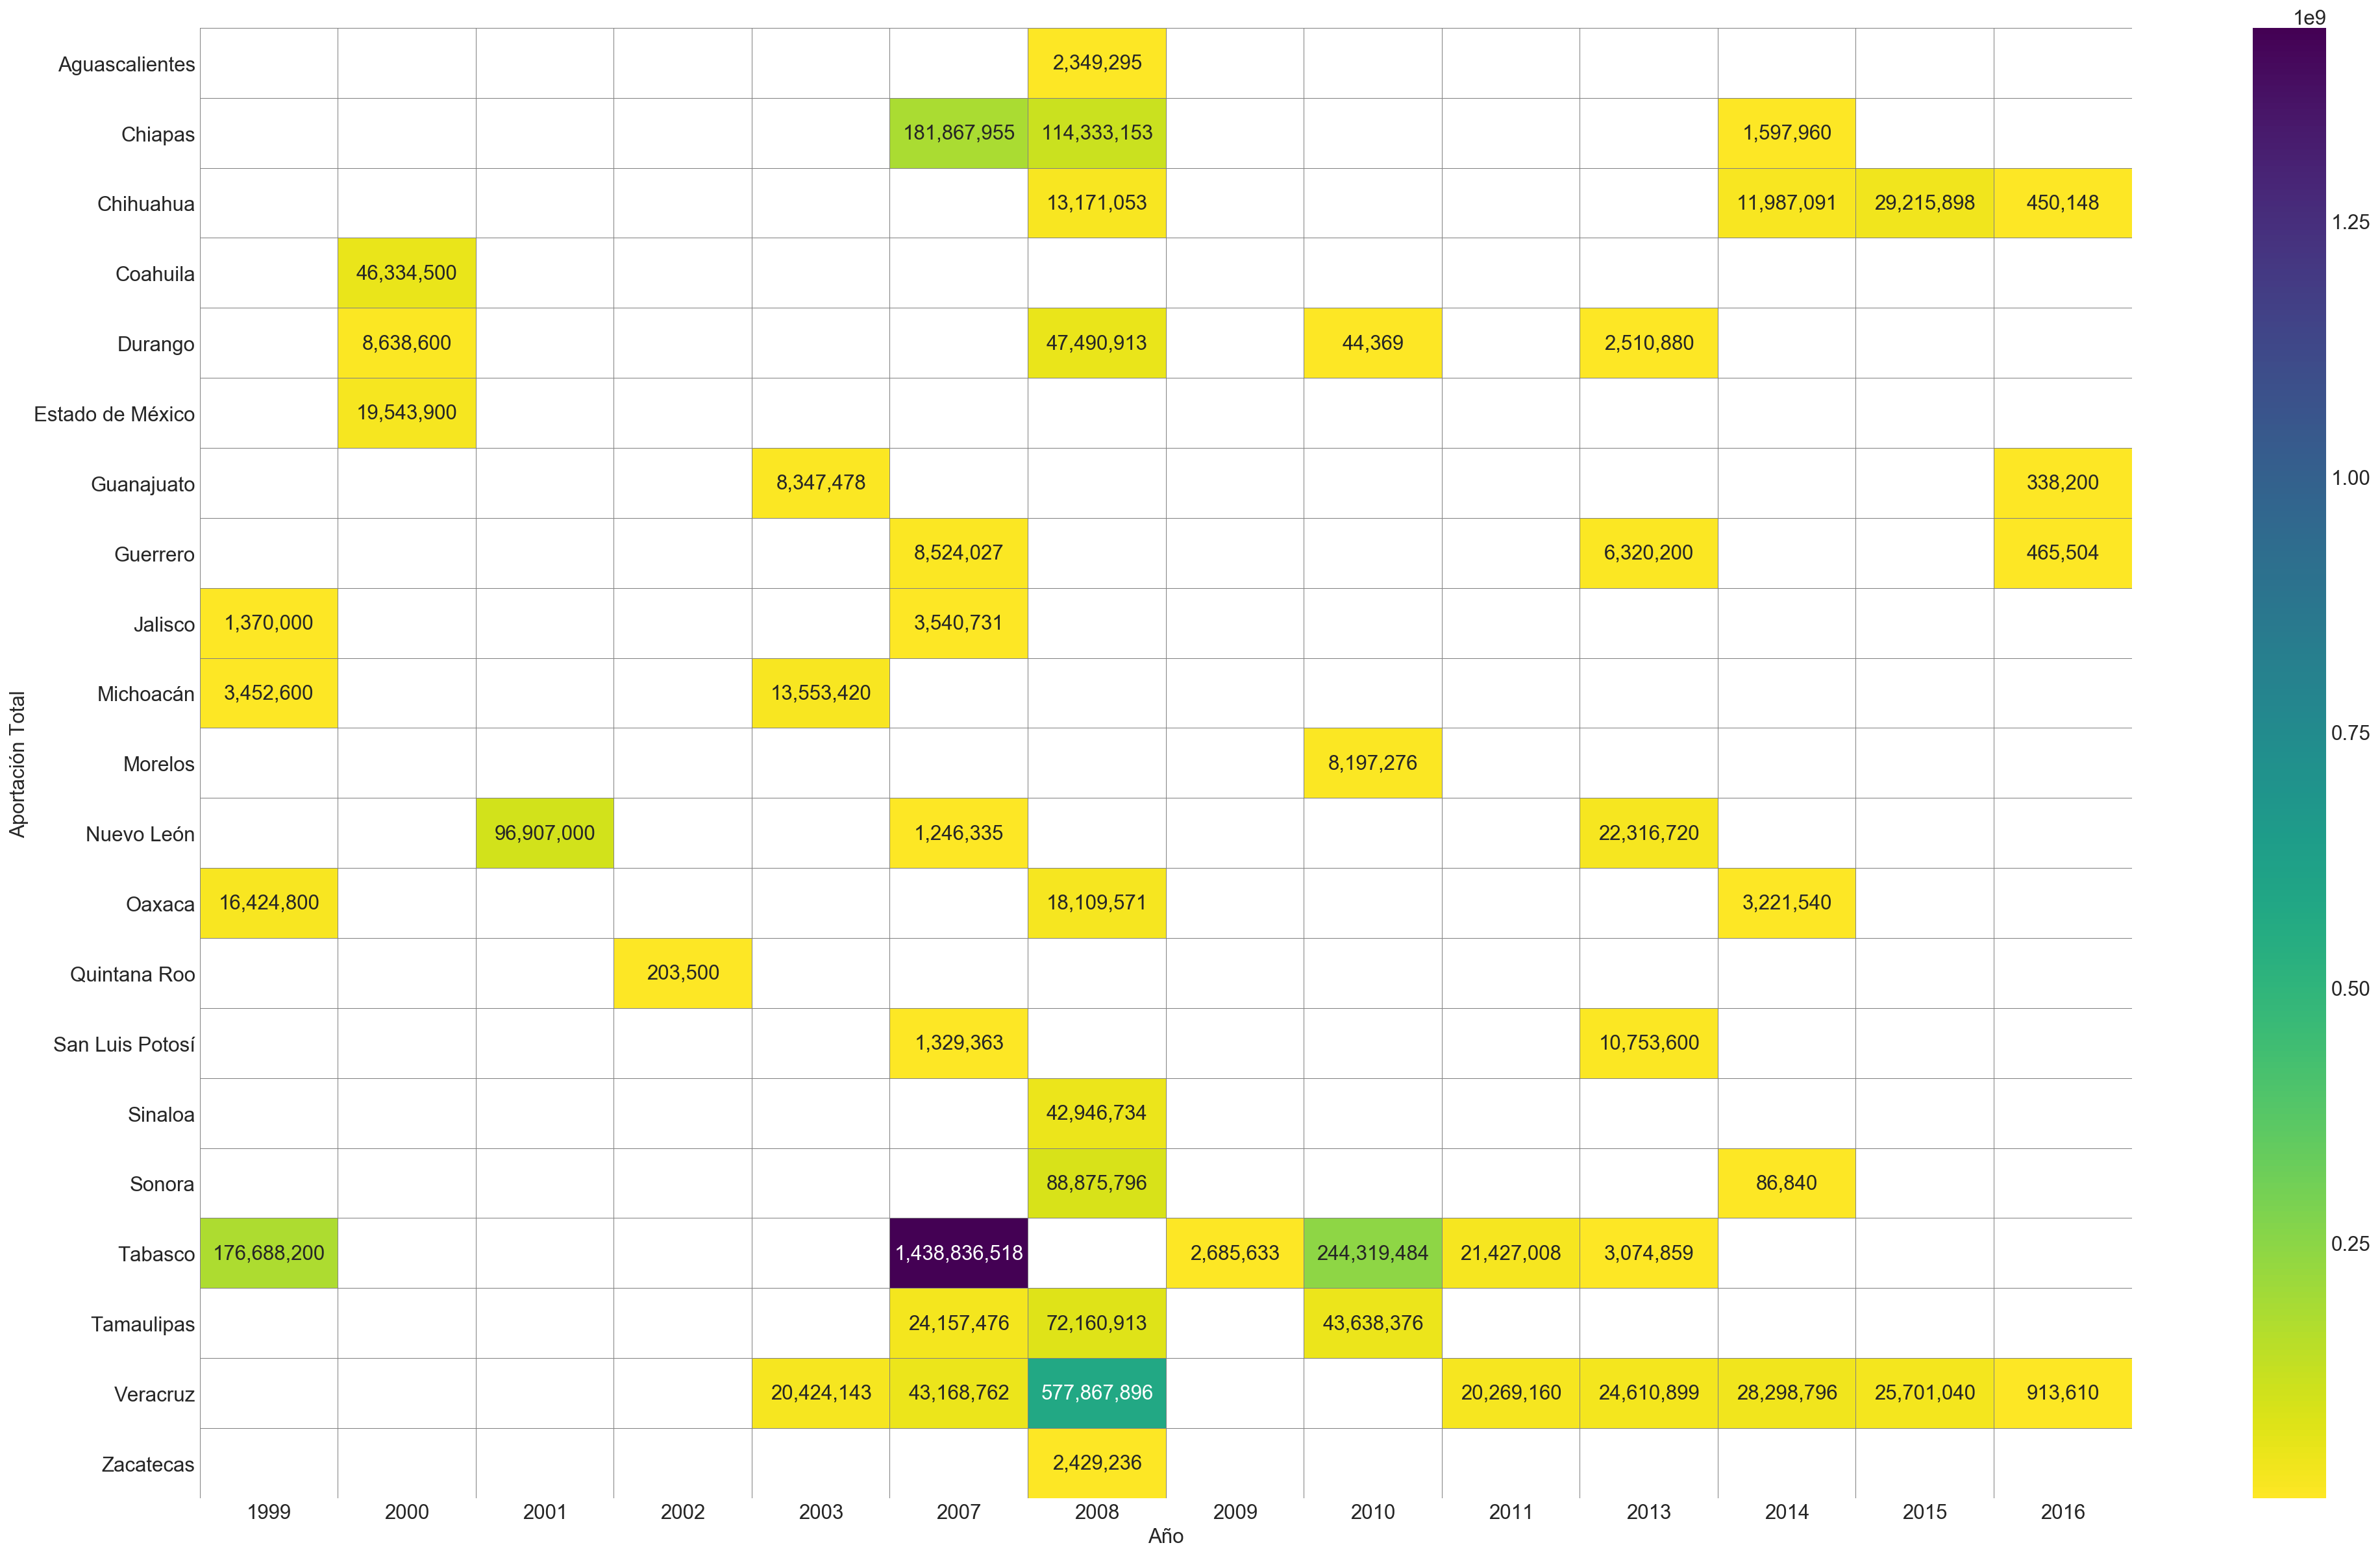

In [254]:
pt_fonden = fonden.pivot_table(values="Aportación TOTAL", columns="Año", index="Estado", aggfunc="sum")
plt.figure(figsize=(32,20), dpi=150)

ax = sns.heatmap(pt_fonden, cmap="viridis_r", annot=True,
                 linewidths=0.005, linecolor="gray", fmt=",.0f",
                 cbar=True, annot_kws={"size":15})
ax.set_xticklabels([int(float(y.get_text())) for y in ax.get_xticklabels()])
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel("Aportación Total", size=15)
plt.xlabel("Año", size=15)
plt.show()

Graficamos la distribución de los siniestros, notámos que el *outlier* de la distribución lo lleva el estado de tabasco

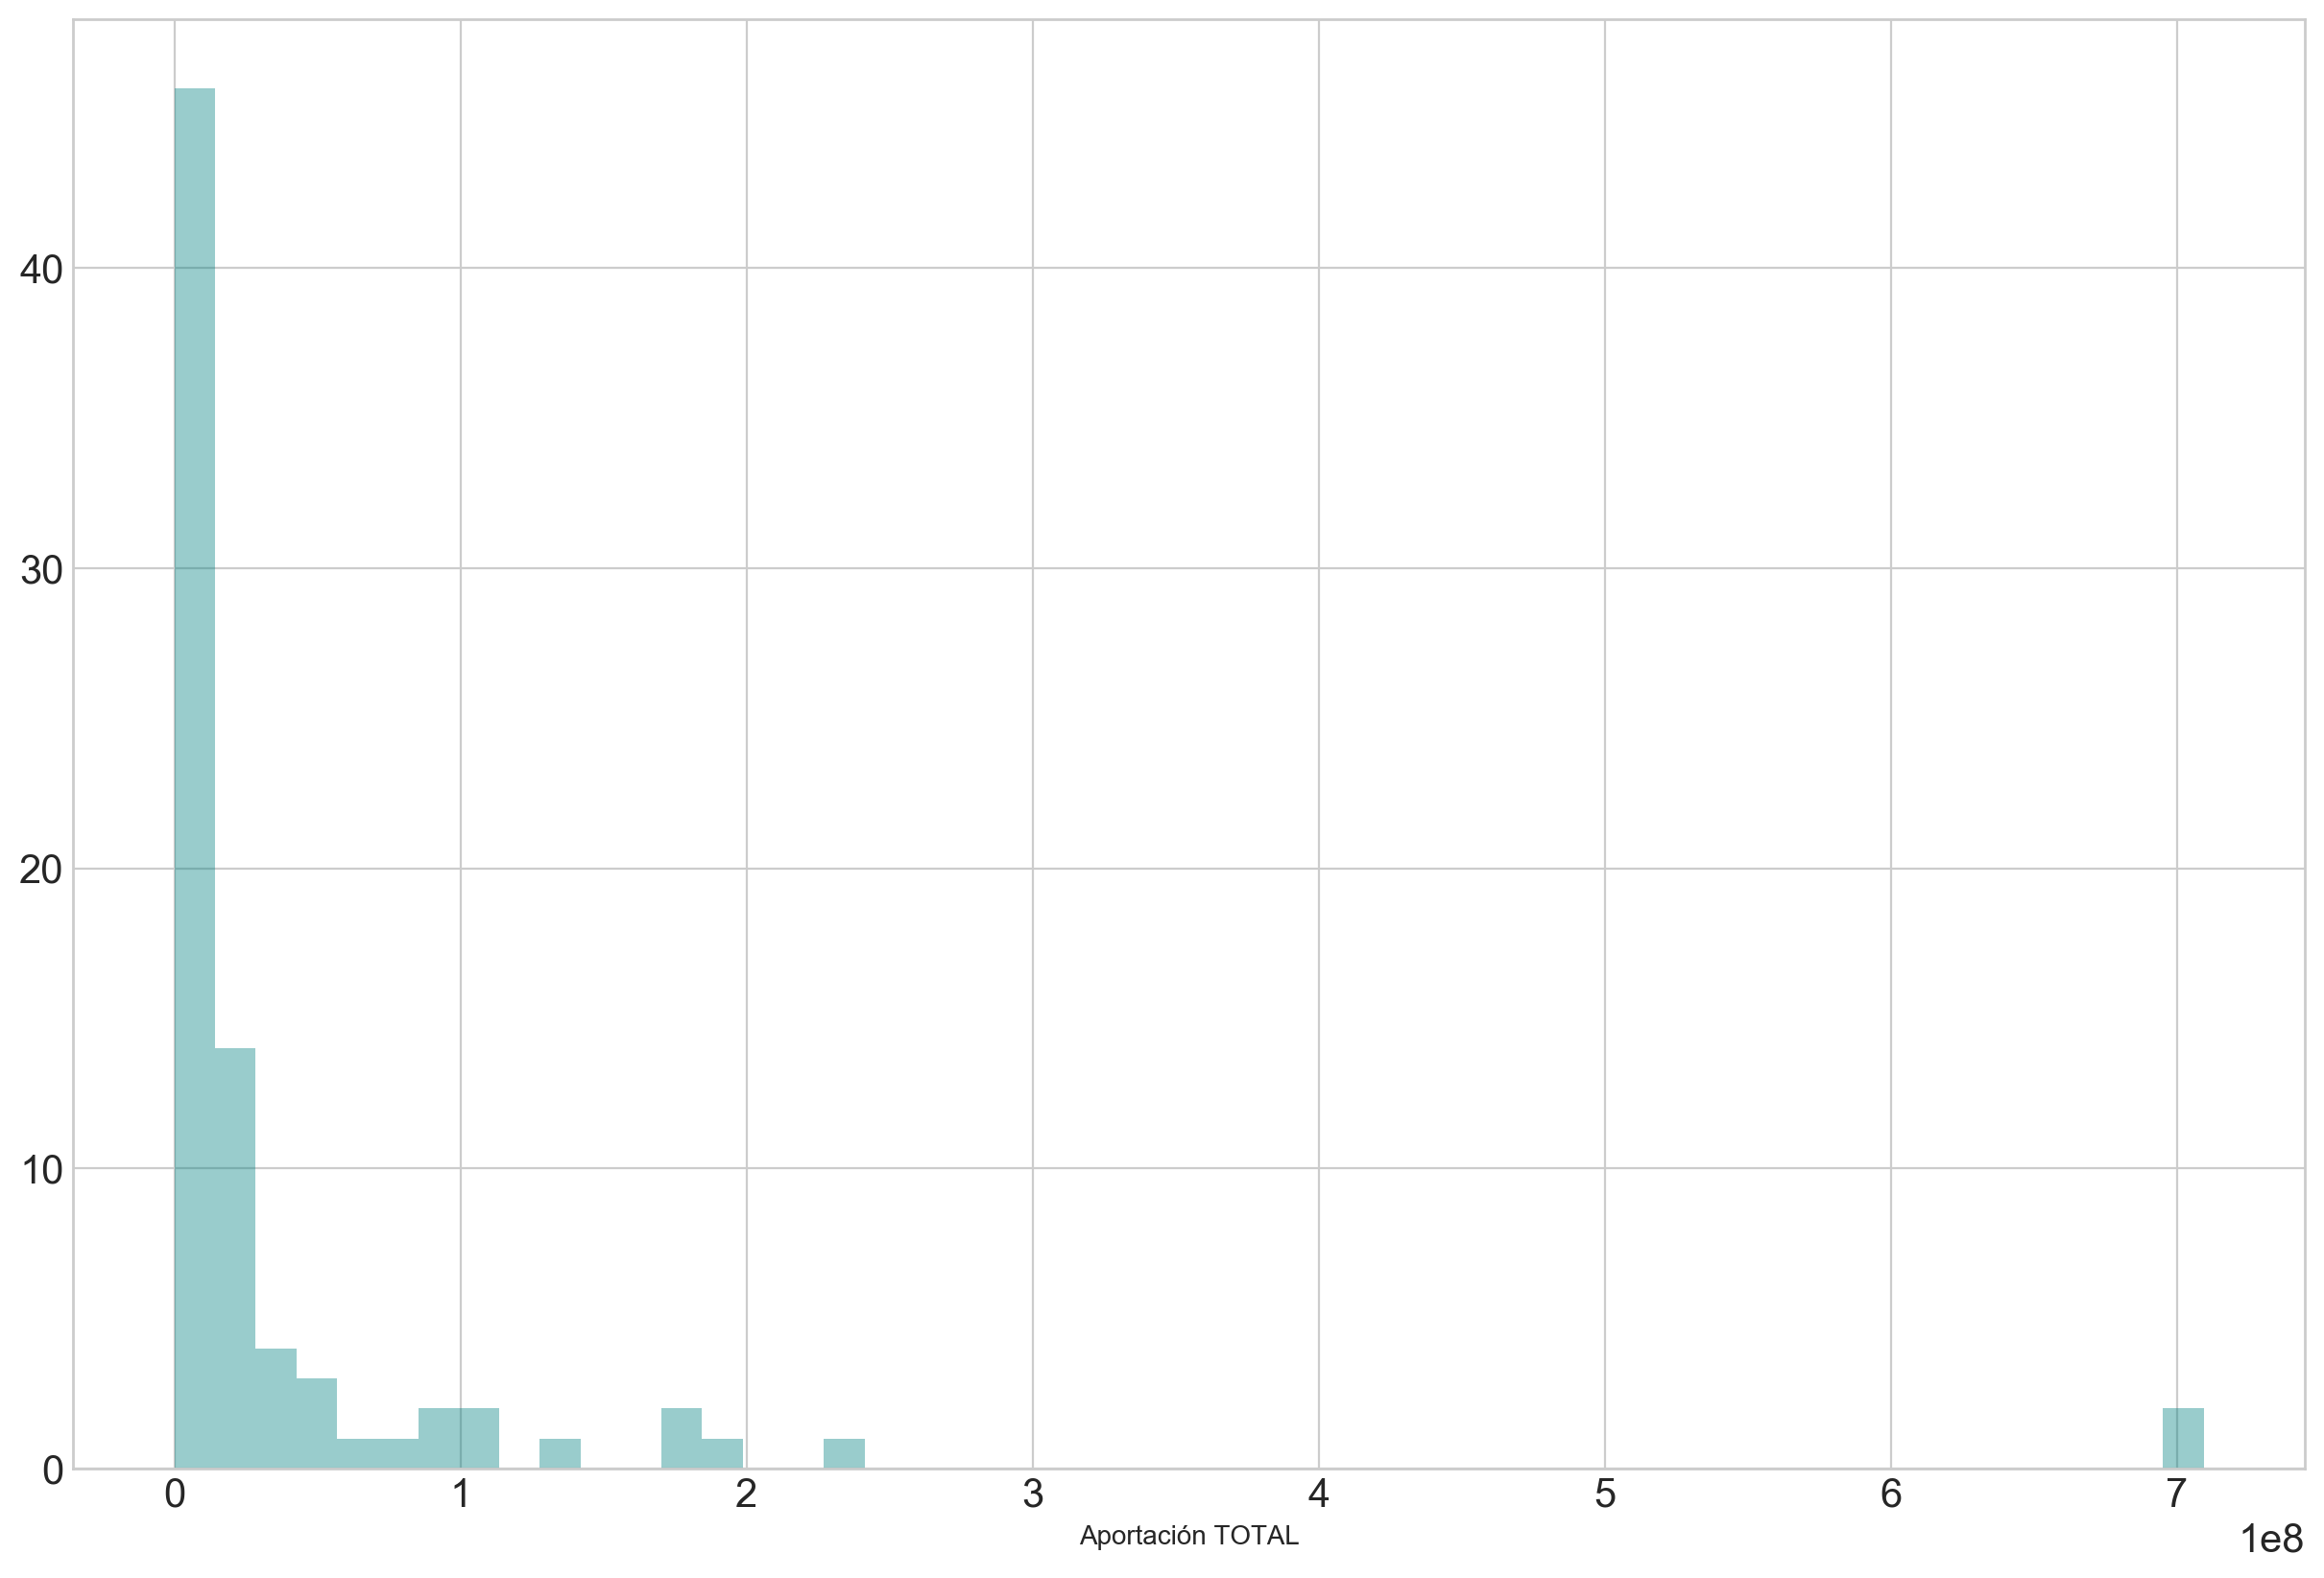

In [151]:
sns.distplot(fonden["Aportación TOTAL"], color="teal", kde=False)
plt.show()

### Cálculo de $\lambda$ para el número de siniestros por año

Contamos, por año, cuantos incidentes se pagaron en total. Lo gráficamos

In [68]:
fonden_count_incidentes = fonden.groupby("Año").count()["Estado"]
fonden_count_incidentes

Año
1999.0     4
2000.0     3
2001.0     2
2002.0     1
2003.0     3
2007.0    12
2008.0    16
2009.0     1
2010.0     6
2011.0     3
2013.0    10
2014.0     9
2015.0     6
2016.0     4
Name: Estado, dtype: int64

In [95]:
years = fonden_count_incidentes.index
minyear = int(min(years))
maxyear = int(max(years))
for year in range(minyear, maxyear):
    if year not in years:
        fonden_count_incidentes[float(year)] = 0
fonden_count_incidentes.sort_index(inplace=True)

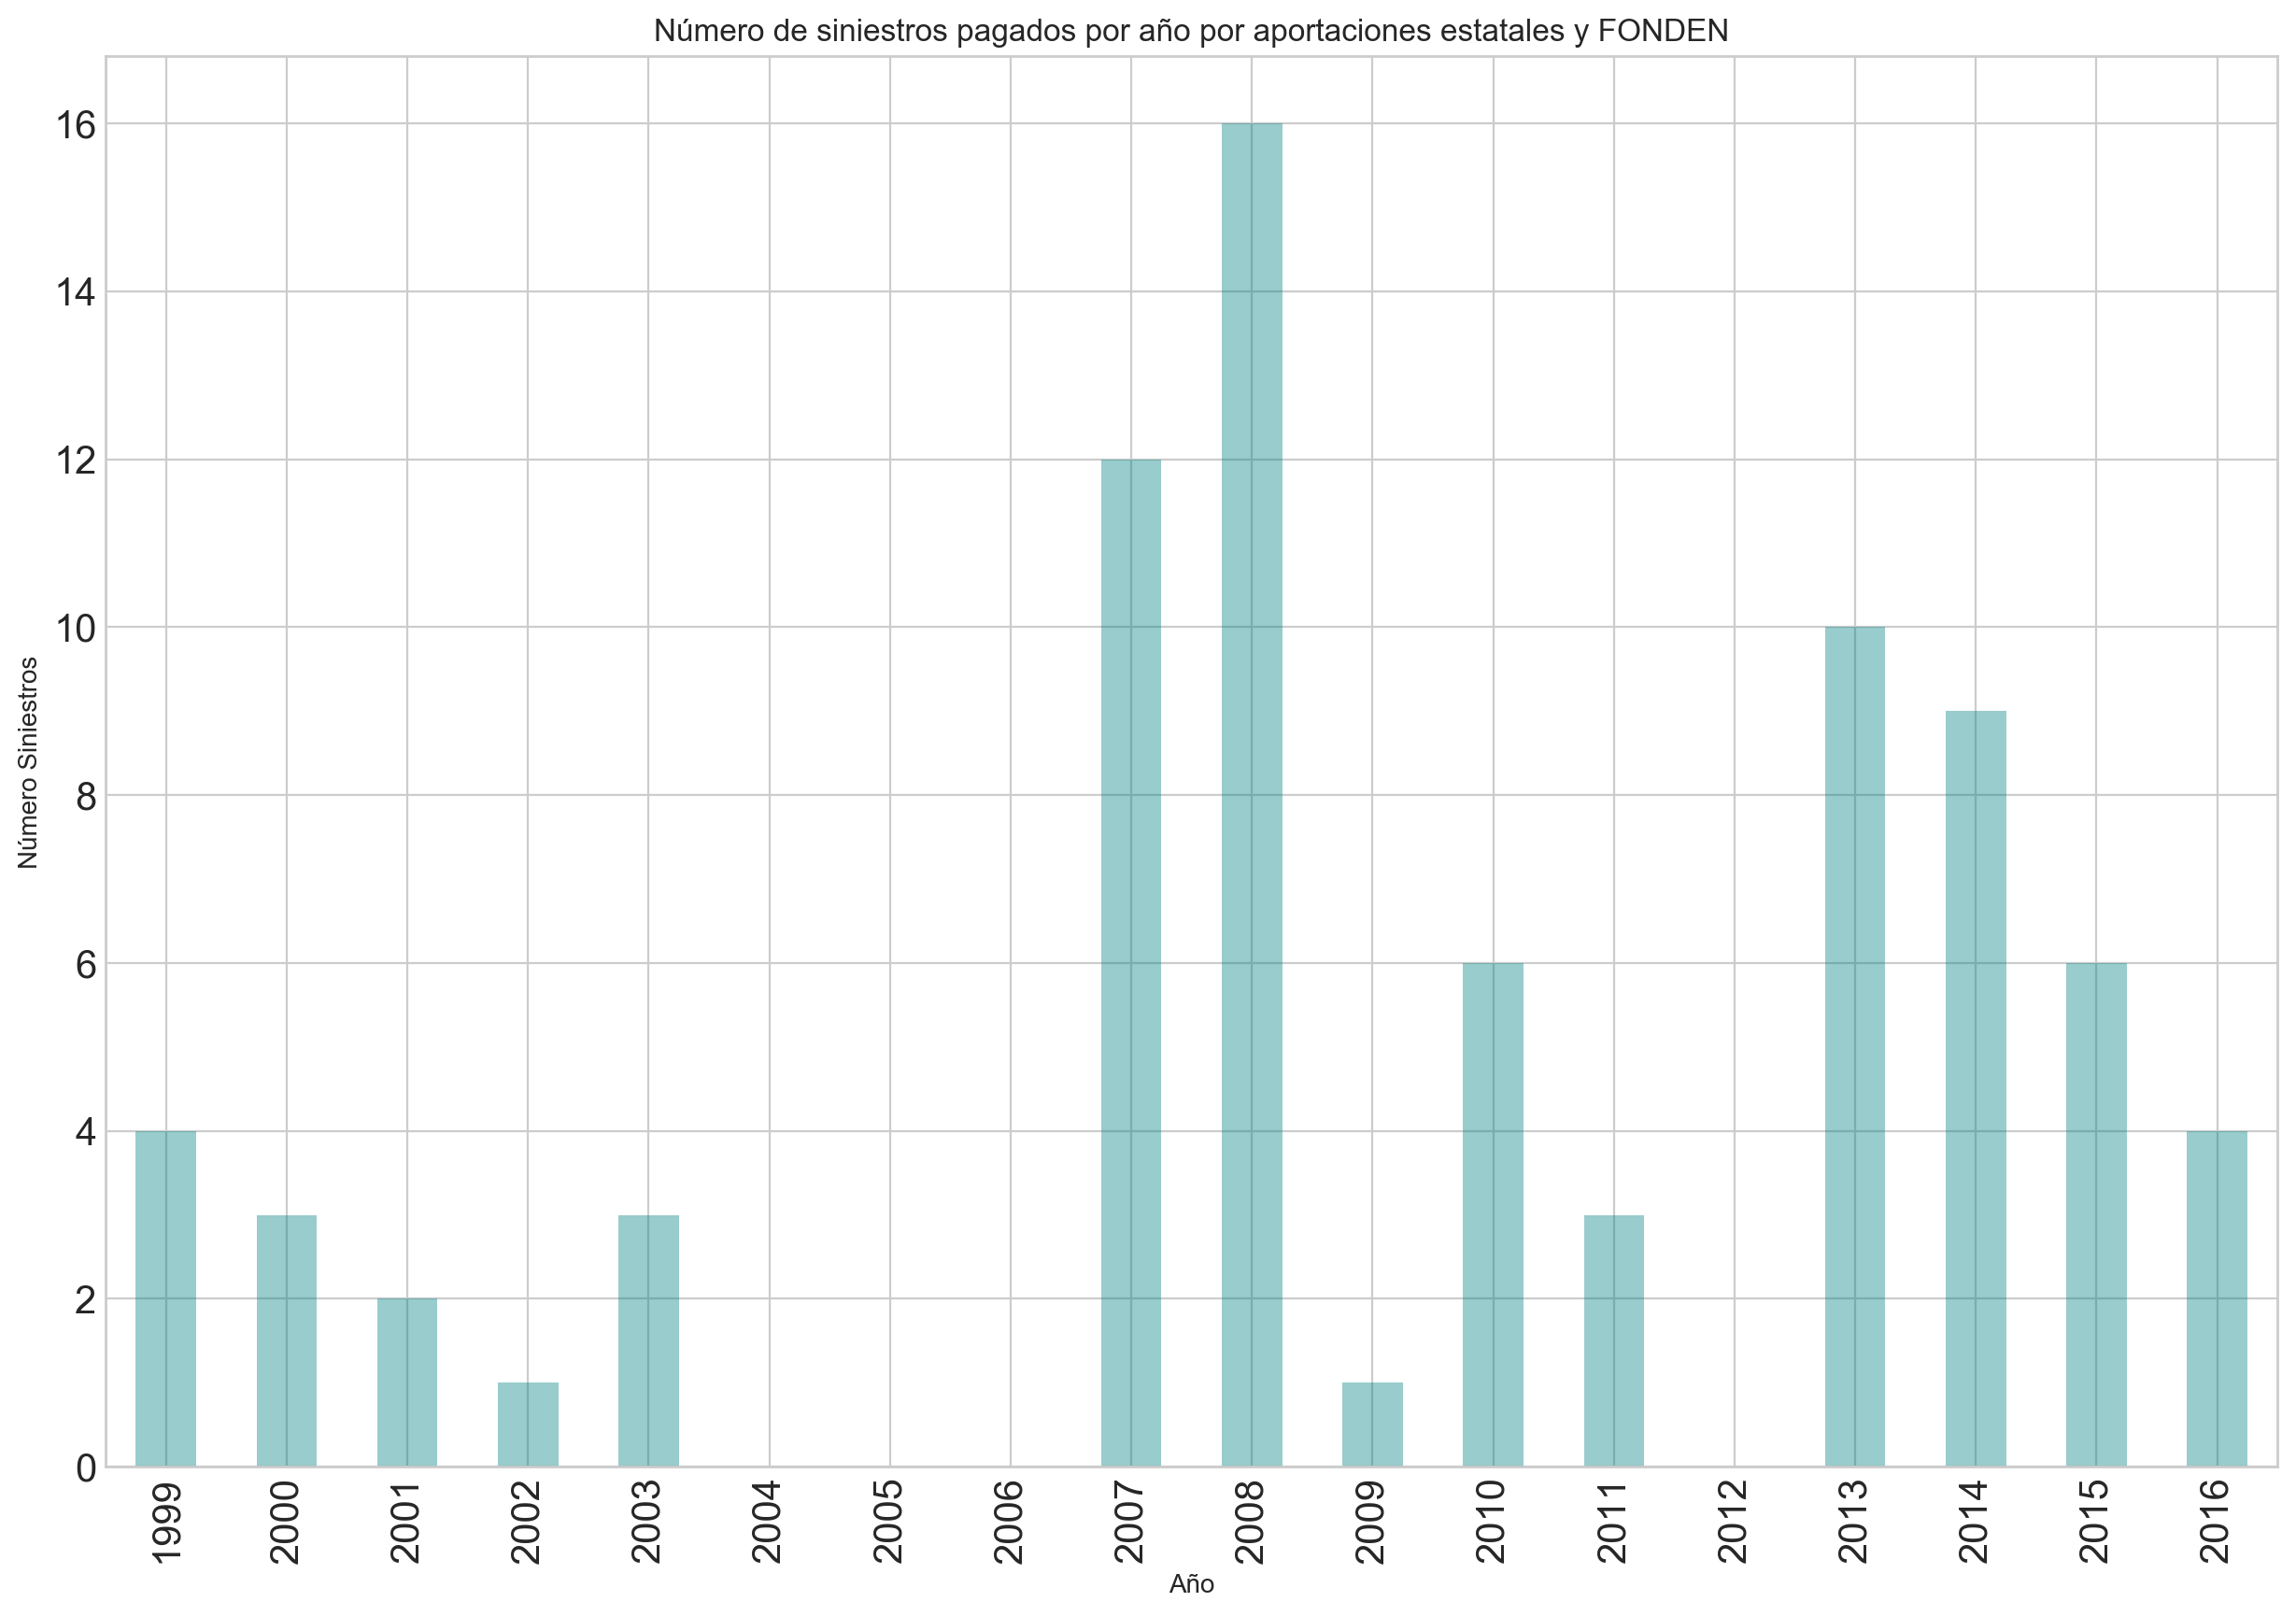

In [152]:
ax = fonden_count_incidentes.plot(kind="bar", color="teal", alpha=0.4)
ax.set_xticklabels([int(float(y.get_text())) for y in ax.get_xticklabels()])
ax.set_title("Número de siniestros pagados por año por aportaciones estatales y FONDEN")
ax.set_ylabel("Número Siniestros")
plt.show()

Con el número de incidentes pagados por año, calculamos el *número promedio de siniestros* por año. Este número, será el parámetro para la distribución de los datos
Esto es, pues asumimos que el número de incidentes por año se distribuye Poisson.

In [329]:
lmbda = fonden_count_incidentes.mean()
lmbda

4.444444444444445

### Cálculo de parametros de Pareto generalizada para la *gravedad* del siniestros

Estimaremos los parametros de la pareto generalizada considerando la función de densidad:

$$
    F_X(x; \mu, \sigma, \epsilon) = 1 - \left(1 + \frac{\epsilon(x - \mu)}{\sigma}\right)^{- 1 / \epsilon}
$$

Considerando que
$$
    \mathbb{E}[X] = \mu + \frac{\sigma}{1 - \epsilon},
$$
$$
    \mathbb{V}[X] = \frac{\sigma^2}{(1 - \epsilon)^2(1 - 2\epsilon)}
$$

Se puede demostrar
$$
    \mu = X^{(1)}, \text{el primer estadístico de orden};
$$
Y, por el método de momentos,
$$
    \hat \epsilon = \frac{1}{2}\left(1 - \frac{(\bar x - \mu)^2}{S^2}\right)
$$
$$
    \hat\sigma = (\bar x - \mu)(1 - \hat \epsilon)
$$

In [335]:
fondentot = fonden["Aportación TOTAL"]
mu = np.percentile(fondentot, 0.85)
mu = fondentot.min()
xbar = fondentot.mean()
s2 = fondentot.var()
epsilon_hat = (1 - (xbar - mu) ** 2 / s2) / 2
sigma_hat = (xbar - mu) * (1 - epsilon_hat)

In [336]:
mu, epsilon_hat, sigma_hat

(44369.0, 0.42608708479163071, 25848961.934938841)

1. Asumimos que nuestros datos (El monto de siniestro) es pareto;
2. Estimamos los parámetros de la distribución pareto; y
3. Gráficamos para una comparación visual.

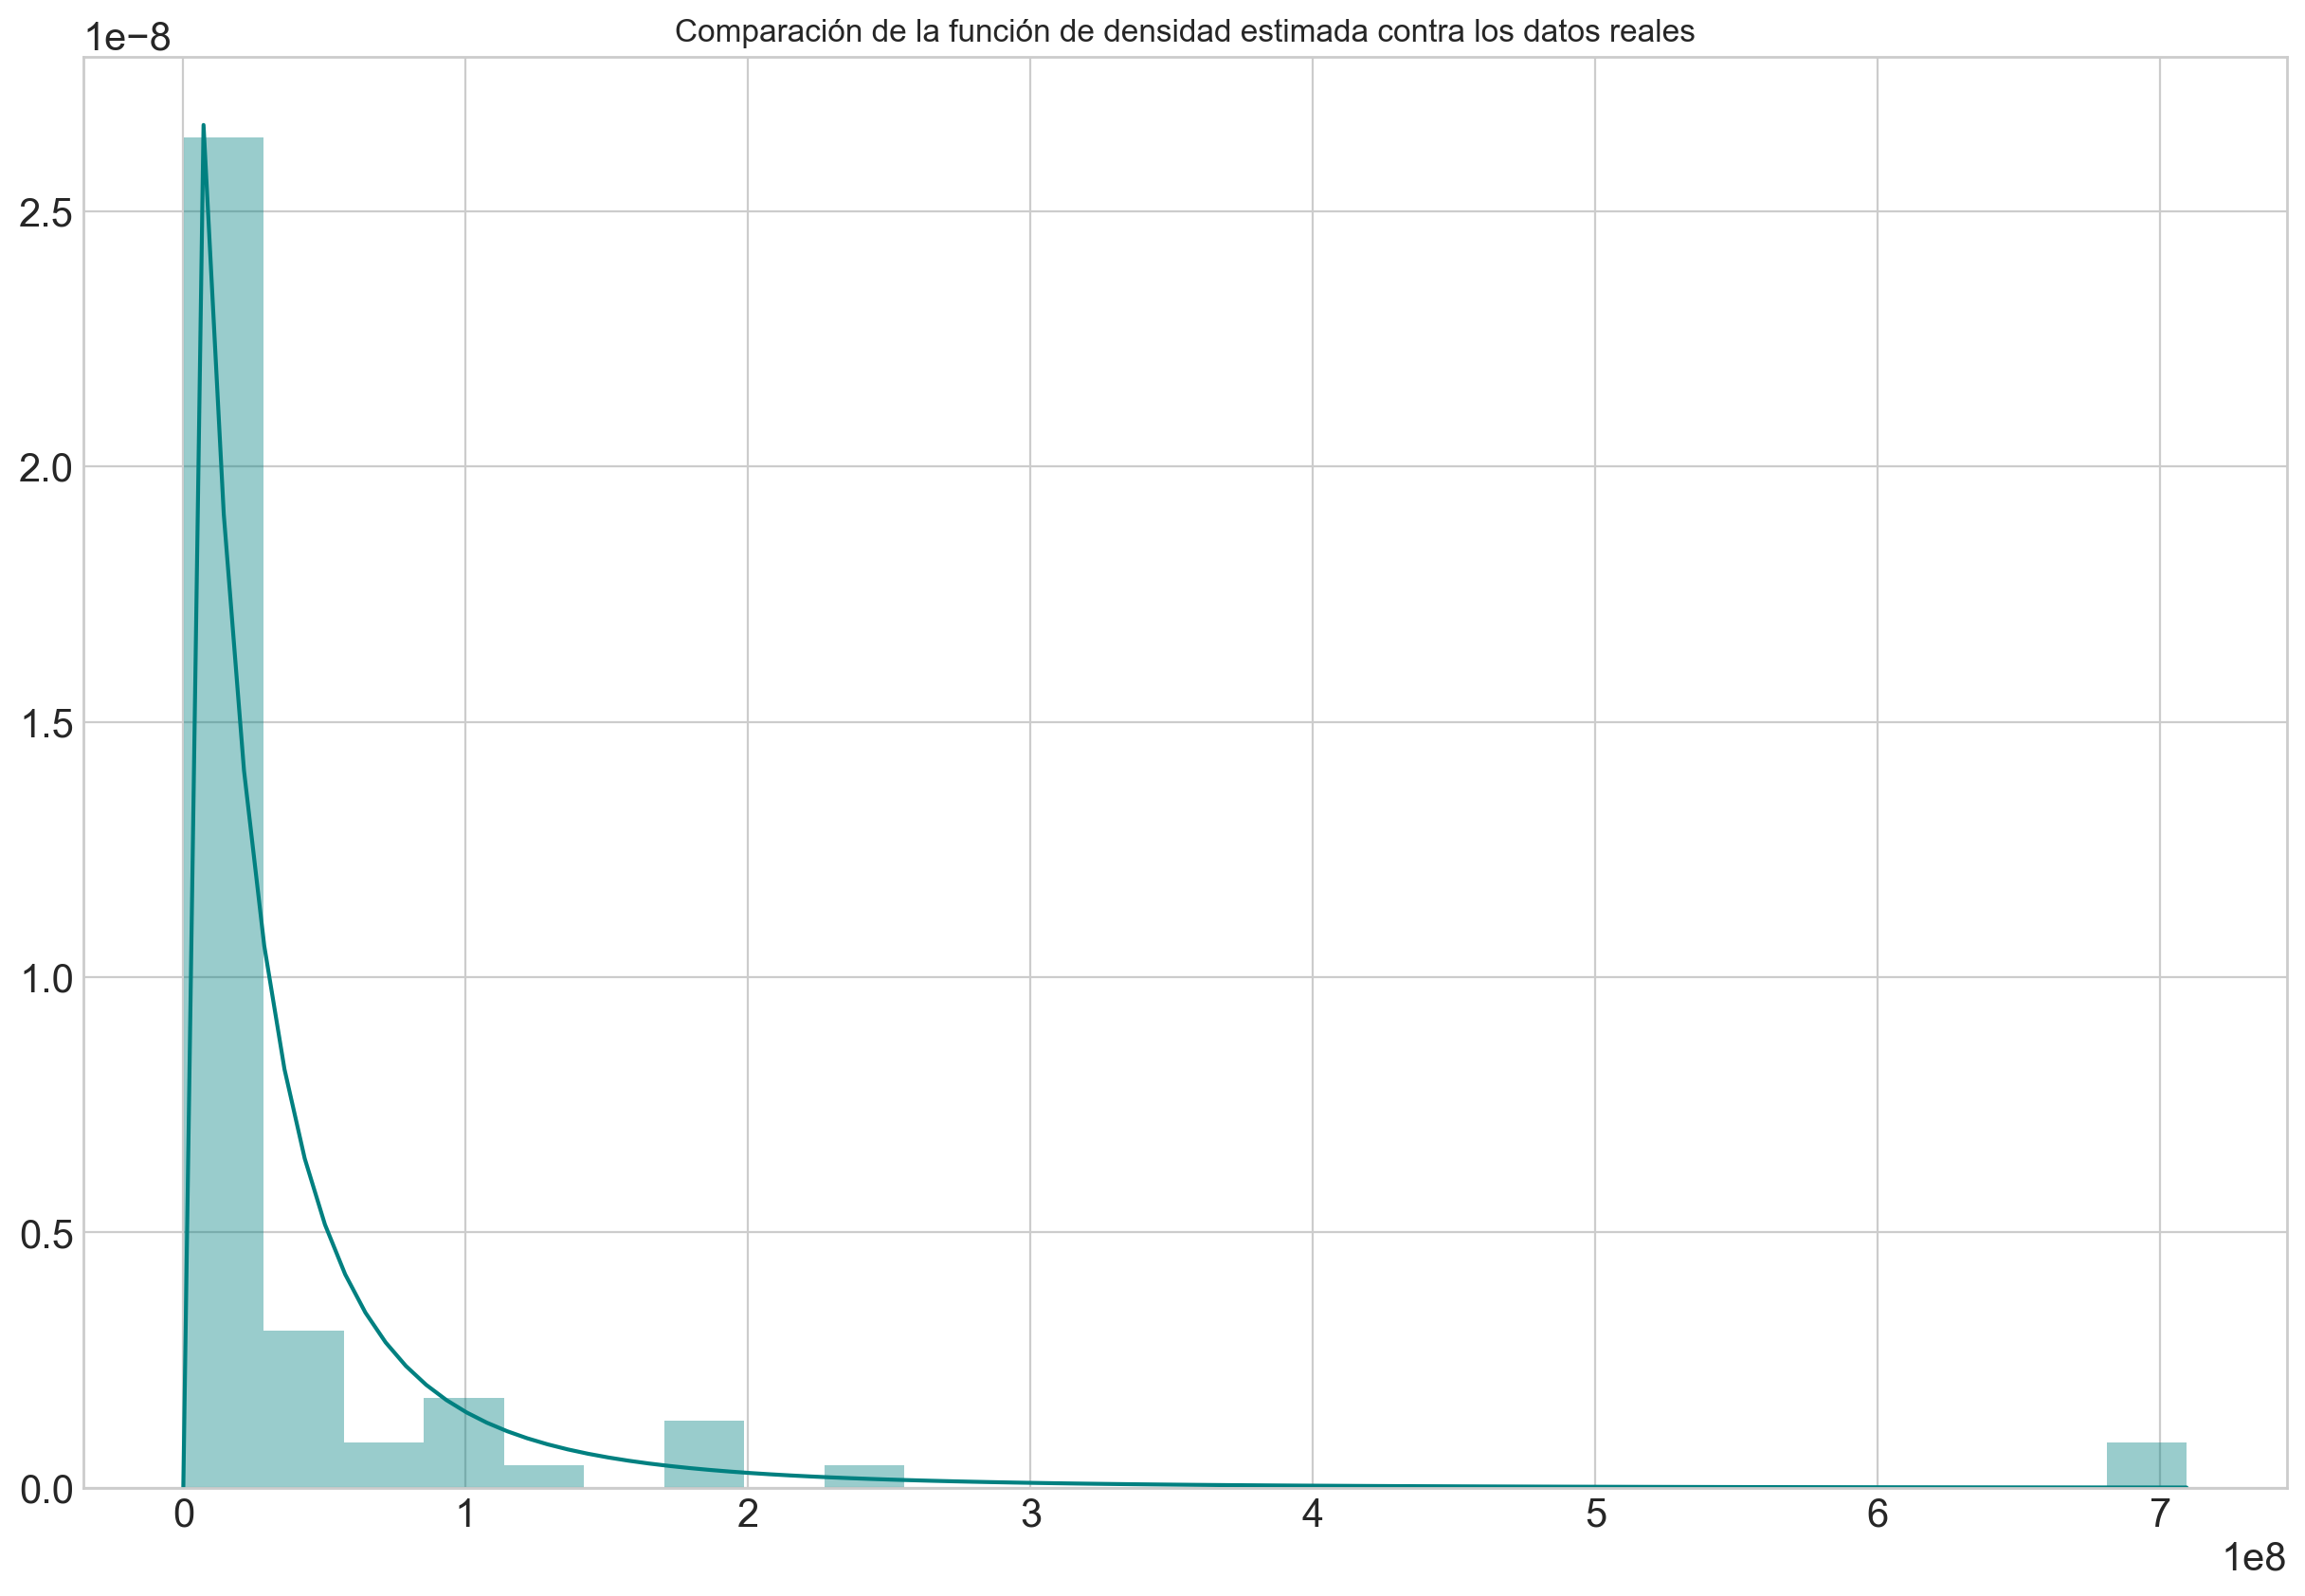

In [337]:
plt.figure(figsize=(15,10), dpi=200)
xrange = np.linspace(0, fondentot.max(), 100)
pdffonden = genpareto.pdf(xrange, epsilon_hat, mu, sigma_hat)
plt.plot(xrange, pdffonden, color="teal")
plt.hist(fondentot,  normed=True, bins=25, color="teal", alpha=0.4)
plt.title("Comparación de la función de densidad estimada contra los datos reales")
plt.show()

# Calculo de la prima de riesgo

In [338]:
from scipy.stats import poisson, genpareto

In [431]:
incidents = poisson.rvs(lmbda, size=1_000)

In [432]:
Sv = []
for n_inc in incidents:
    vals = genpareto.rvs(epsilon_hat, mu, sigma_hat, size=n_inc)
    Sv.append(sum(vals))

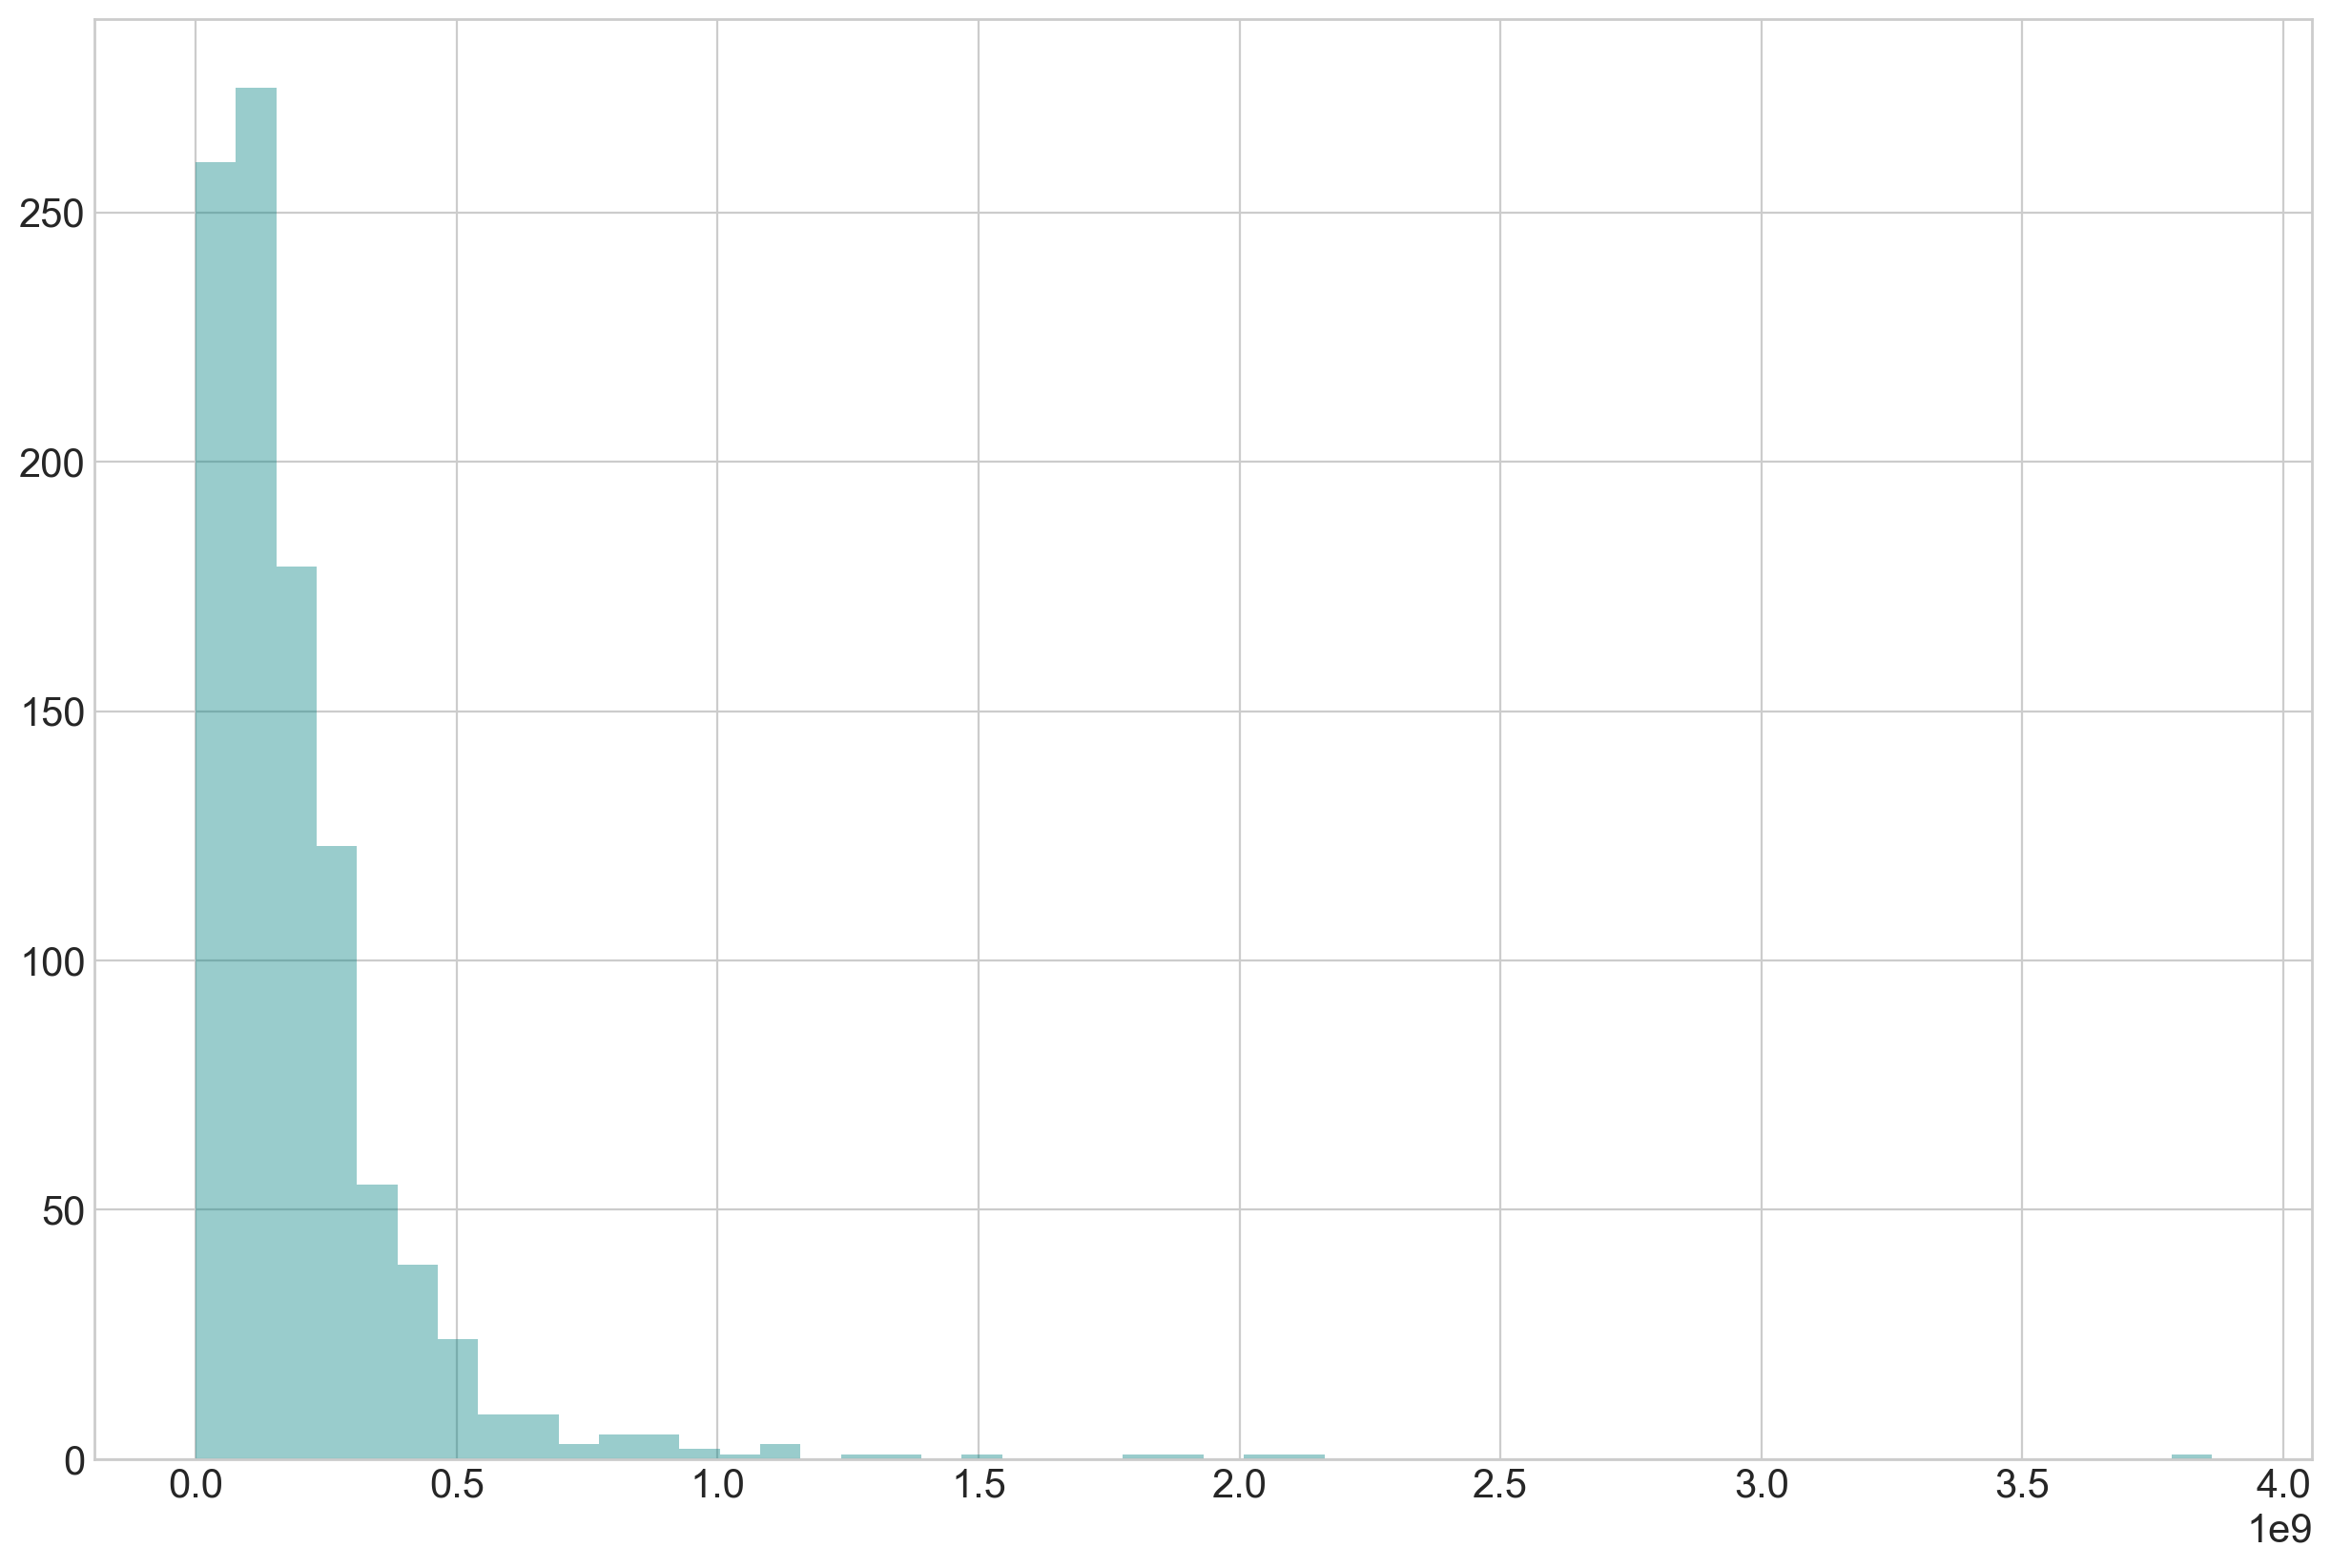

In [433]:
ax = sns.distplot(Sv, bins=50, color="teal", kde=False)
plt.show()

In [434]:
print(f"Prima media por estado: ${np.mean(Sv):,.2f}")

Prima media por estado: $199,526,126.54


Leemos el archivo de INEGI con la densidad por múnicipio hacia el año 2010

In [435]:
columns = ["code", "municipio", "total", "hombre", "mujer"]
mun_density = pd.read_csv("./data/INEGI_Exporta_20171203132943.csv",
                          skipfooter=2, skiprows=4, encoding="ISO 8859-1",
                          engine="python", thousands=",")
mun_density.columns = columns
# Remove states
mun_density.query("code != '#NAME?'", inplace=True)

Leemos archivo de alto riesgo por municipio

In [436]:
mun_high_risk = pd.read_csv("./data/high_risk.csv")
mun_high_risk = mun_high_risk["mun"].values.tolist()

In [437]:
total_municipalities = 0
count_municipalities = 0
for row in mun_density[["municipio", "total"]].iterrows():
    municipality, density = row[1].values
    municipality = municipality.upper()
    for ix, mun in enumerate(mun_high_risk):
        if fuzz.ratio(mun, municipality) > 90:
            total_municipalities += density
            count_municipalities += 1
            del mun_high_risk[ix]
            break

In [438]:
count_municipalities

117

In [439]:
print(f"Prima media por municipio con alto riesgo: ${np.mean(Sv)/total_municipalities:,.2f}")

Prima media por municipio con alto riesgo: $8.49


In [445]:
print(f"Prima media por municipio con alto riesgo: ${np.mean(Sv)/117:,.2f}")

Prima media por municipio con alto riesgo: $1,705,351.51


In [444]:
f"{total_municipalities:,.0f}"

'23,495,641'